In [2]:
import sys
import time
print(sys.executable)
from utils import *
import matplotlib.ticker as plticker
import seaborn as sns
import random
import hdbscan
time_dic = {
    2015:[(2014, 11), (2014, 12)] + ([(2015, m) for m in range(1, 11)]),
    2016:[(2015, 11), (2015, 12)] + ([(2016, m) for m in range(1, 11)]),
    2017:[(2016, 11), (2016, 12)] + ([(2017, m) for m in range(1, 11)]),
    2018:[(2017, 11), (2017, 12)] + ([(2018, m) for m in range(1, 11)]),
    2019:[(2018, 11), (2018, 12)] + ([(2019, m) for m in range(1, 11)])
}

/Users/clivian/opt/anaconda3/bin/python


<ipython-input-3-699a40260e71>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(year_x)
<ipython-input-3-699a40260e71>:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


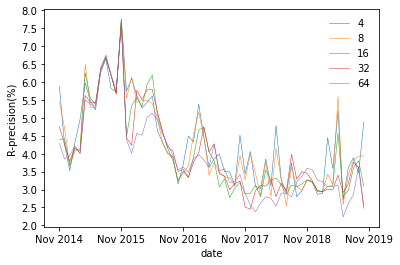

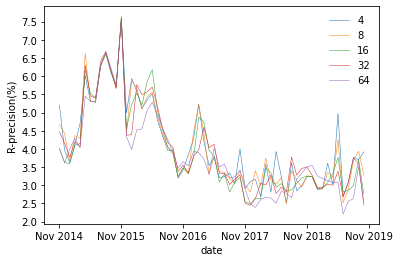

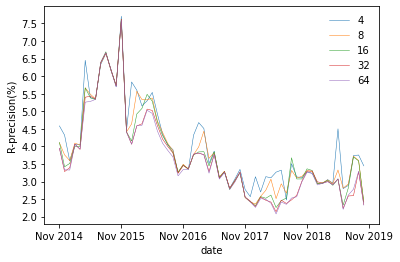

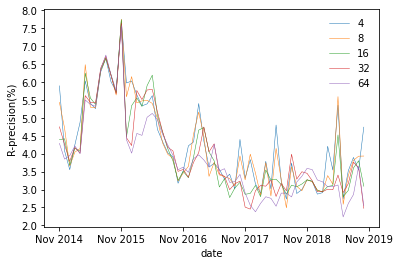

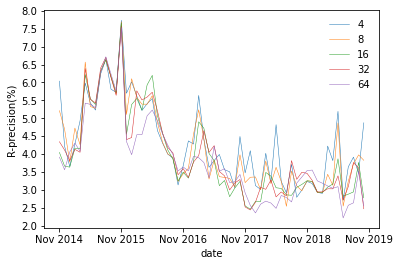

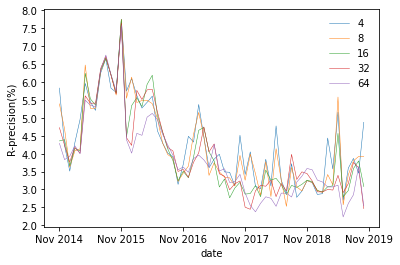

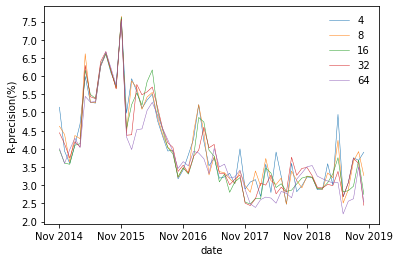

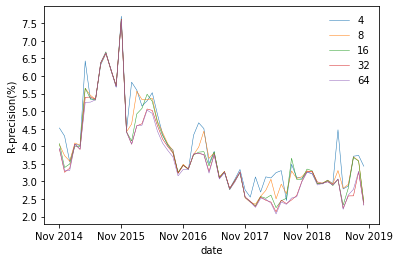

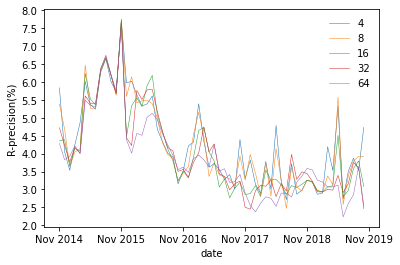

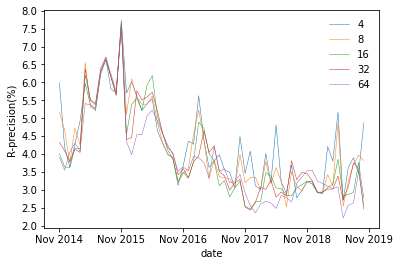

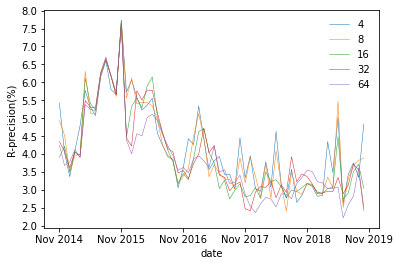

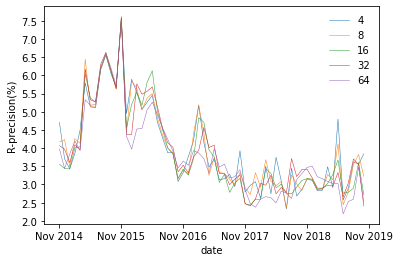

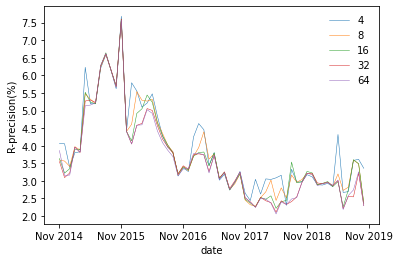

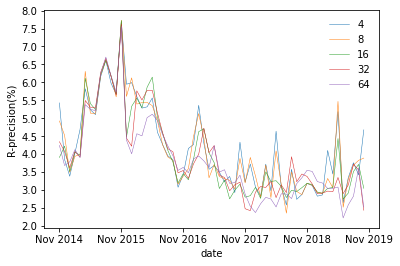

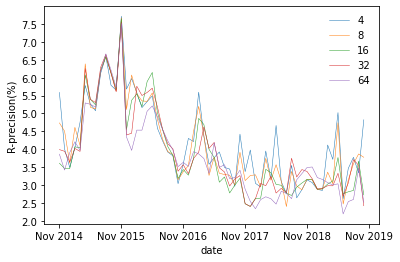

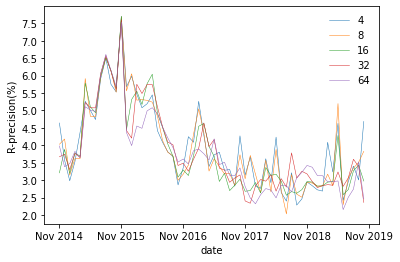

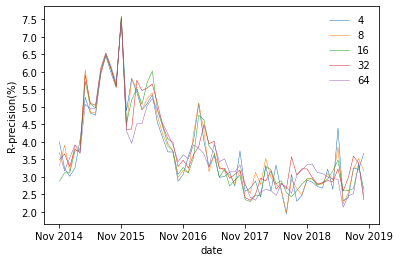

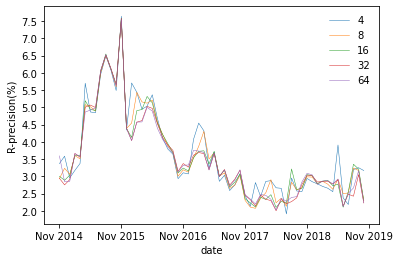

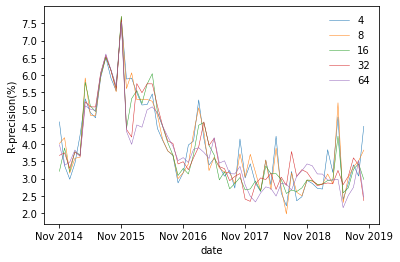

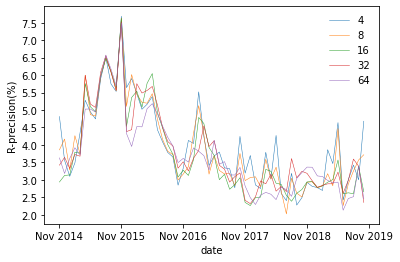

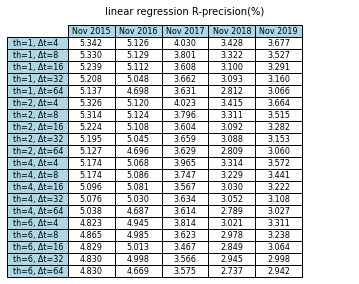

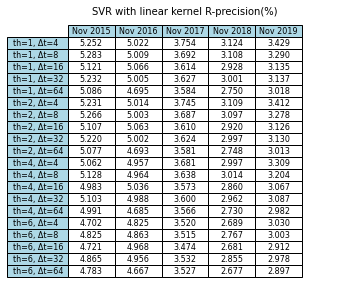

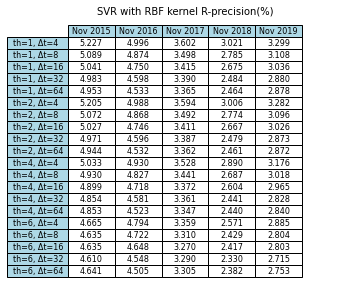

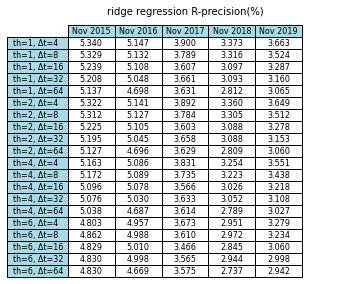

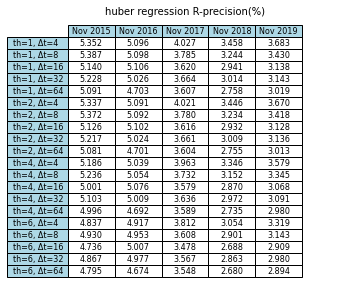

In [3]:
timeline_aves = np.load(os.path.join('data', 'day_ave_smoothed_timeline_algo.npy'), allow_pickle=True).tolist()
threshold_list = [1, 2, 4, 6]
timeline_param_list = [4, 8, 16, 32, 64]
yearly_aves_grid = {}
for i in range(len(threshold_list)):
    timeline_year_aves = []
    timeline_month_aves = []
    timeline_methods = ['linear regression', 'SVR with linear kernel', 'SVR with RBF kernel',
                       'ridge regression', 'huber regression']
    for method in range(len(timeline_methods)):
        timeline_year_aves_per_method = []
        timeline_month_aves_per_method = []
        for j in range(len(timeline_aves[i])):
            timeline_ave = timeline_aves[i][j]
            year_ave_per_param = []
            month_ave_per_param = []
            for _year in range(2015, 2020):
                year_value = []
                for year, month in time_dic[_year]:
                    month_value = []
                    for day in range(1, 32):
                        value = timeline_ave.get((year, month, day), -1)
                        if value != -1:
                            year_value.append(value[method])
                            month_value.append(value[method])
                    month_ave_per_param.append(sum(month_value) / len(month_value) * 100)
                year_ave_per_param.append("%.3f" % (sum(year_value) / len(year_value) * 100))
            timeline_year_aves_per_method.append(year_ave_per_param)
            timeline_month_aves_per_method.append(month_ave_per_param)
            if method not in yearly_aves_grid:
                yearly_aves_grid[method] = []
            yearly_aves_grid[method].append([(threshold_list[i], timeline_param_list[j]),
                                             year_ave_per_param])
        timeline_year_aves.append(timeline_year_aves_per_method)
        timeline_month_aves.append(timeline_month_aves_per_method)
    
    # plot monthly and yearly ave
    for method in range(len(timeline_methods)):
        year_x = ['']
        temp_x = [i for i in range(0, 60)]
        for year in range(2014, 2020):
            year_x.append('Nov ' + str(year))
        fig, ax = plt.subplots()
        x_loc = plticker.MultipleLocator(base=12)
        y_loc = plticker.MultipleLocator(base=0.5)
        ax.xaxis.set_major_locator(x_loc)
        ax.yaxis.set_major_locator(y_loc)
        for j in range(0, len(timeline_param_list)):
            param = timeline_param_list[j]
            ax.plot(temp_x, timeline_month_aves[method][j], linewidth=0.5, label=str(param))
        ax.legend(loc='upper right', frameon=False)
        ax.set_xticklabels(year_x)
        ax.set_xlabel('date')
        ax.set_ylabel('R-precision(%)' )
        fig.savefig('./figures/timeline_algo_figures/smoothed_monthly_average_th' + str(threshold_list[i])
                    + '_' + str(timeline_methods[method]), bbox_inches='tight', dpi=300)
for method in range(len(timeline_methods)):
    # prepare grid-searched yearly average
    row_headers = ['th=' + str(item[0][0]) + ', Δt=' + str(item[0][1])  
                   for item in yearly_aves_grid[method]]
    cell_text = [item[1] for item in yearly_aves_grid[method]]
    fig, ax = plt.subplots() 
    ax.set_axis_off() 
    ax.set_title(str(timeline_methods[method]) + ' R-precision(%)'
        , loc='center', fontsize=10)
    table = ax.table(
        cellText = cell_text,
        rowLabels = row_headers,
        colLabels = ['Nov ' + str(year) for year in range(2015, 2021)],
        rowColours = ["lightblue"] * len(cell_text),  
        colColours = ["lightblue"] * len(cell_text[0]), 
        colWidths= [0.14] * len(cell_text[0]),
        cellLoc ='center',
        loc ='upper center',
    )
    bbox = table.get_window_extent(fig.canvas.get_renderer())
    bbox = bbox.from_extents(bbox.xmin-5, bbox.ymin-5, bbox.xmax+5, bbox.ymax+25)
    bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('./figures/timeline_algo_figures/smoothed_yearly_average_th' + str(threshold_list[i])
                + '_' + str(timeline_methods[method]), bbox_inches=bbox_inches, dpi=300)